# Clustering of Neighborhoods by Mexican Food Type

Constantino Carreto Romero

Let's suppose we are in the food bussiness, specifically in the mexican street food (e.g. tacos, quesadillas, etc.). We want to expand our bussiness by starting new branches in Mexico City. If we for example sell tacos, where could we place each new branch so there is low competition but at the same time a lot of potential customers? To answer this questions it might be helpful to group neighborhoods according to the predominance of different types of mexican street food. Based on this grouping we might spot addecuate neighborhoods where we potentially might place our new branches.

<section id="item0"> </section>

## Table of Contents

1.  <a href="#item1">Collect Neighborhoods' Coordinates</a>
2.  <a href="#item2">Collect Venues in each Neighborhood</a>  

    2A. <a href="#item2A">Foursquare API</a> 
    
    2B. <a href="#item2B">Street food Representativeness per Neighborhood</a> 


3.  <a href="#item3">Clustering Neighborhoods</a> 
4.  <a href="#item4">Examining Clusters</a> 


In [1]:
# import labraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import requests # for making the request to the website
import json # to transform to json file
import lxml.html as lh # for parsing html content

#!pip install pgeocode
import pgeocode # to obtain latitude and longitude coordinates

# import k-means from clustering stage
from sklearn.cluster import KMeans

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

#!pip install folium==0.5.0
import folium # map rendering library

import os # to access working directory

# standarize
from sklearn.preprocessing import StandardScaler
print('libraries imported')

libraries imported


<section id="item1"> </section>

## 1. Collect Neighborhoods' Coordinates

We use neighborhoods' postal codes to collect their geo-coordinates.

In [4]:
# download and load postal codes from: https://www.correosdemexico.gob.mx/SSLServicios/ConsultaCP/CodigoPostal_Exportar.aspx
file = 'F:/practicas_python/data_science_ibm/capstone_project/Ciudad de México.xls'
df = pd.read_excel(file, sheet_name='Distrito_Federal')
df = df[['d_codigo', 'd_asenta', 'D_mnpio']].rename(columns={'d_codigo':'Postal Code', 'd_asenta':'Neighborhood', 'D_mnpio':'Borough'})
df.head()

,Postal Code,Neighborhood,Borough
0,1000,San Ángel,Álvaro Obregón
1,1010,Los Alpes,Álvaro Obregón
2,1020,Guadalupe Inn,Álvaro Obregón
3,1030,Axotla,Álvaro Obregón
4,1030,Florida,Álvaro Obregón


In [5]:
# fix postal codes codification
df['Postal Code2'] = df['Postal Code'].astype('str')
df.loc[df['Postal Code']<10000, 'Postal Code2'] = '0' + df.loc[df['Postal Code']<10000, 'Postal Code2']
df.drop(columns='Postal Code', inplace = True)
df.rename(columns={'Postal Code2': 'Postal Code'}, inplace = True)
df= df[['Postal Code', 'Borough', 'Neighborhood']]
df.head()

,Postal Code,Borough,Neighborhood
0,01000,Álvaro Obregón,San Ángel
1,01010,Álvaro Obregón,Los Alpes
2,01020,Álvaro Obregón,Guadalupe Inn
3,01030,Álvaro Obregón,Axotla
4,01030,Álvaro Obregón,Florida


In [6]:
# let's clean the dataframe
# we merge nieghbourhoods with the same zip code
if len(df['Postal Code'].unique())==df.shape[0]:
    print('we have no zip code repetitions')
else:
    print('postal codes repeated')
print(len(df['Postal Code'].unique()), df.shape)

postal codes repeated
1102 (1515, 3)


In [7]:
df['Neighborhood'] = df['Neighborhood'] + ', '
df['Borough'] = df['Borough'] + ', '

In [8]:
df2 = df.groupby('Postal Code')[['Neighborhood', 'Borough']].sum().reset_index()
df2['Neighborhood'] = df2['Neighborhood'].str.strip(', ')
df2['Borough'] = df2['Borough'].str.strip(', ')
print( df2.shape)
df2.head()

(1102, 3)


,Postal Code,Neighborhood,Borough
0,01000,San Ángel,Álvaro Obregón
1,01010,Los Alpes,Álvaro Obregón
2,01020,Guadalupe Inn,Álvaro Obregón
3,01030,"Axotla, Florida","Álvaro Obregón, Álvaro Obregón"
4,01040,Campestre,Álvaro Obregón


In [9]:
# we use pgeocode to get the latitude and longitude corresponding to each postal code
# this takes some time
lat = []
lon = []

# iterate through each postal code
for i, pc in enumerate(df2['Postal Code']):
    #print('processing postal code ', str(i), ' ', pc)
    nomi = pgeocode.Nominatim('mx')
    result = nomi.query_postal_code(pc)
    #print(result)
    lat.append(result[9])
    lon.append(result[10])
    
print(lat[0:5], lon[0:5])

[19.3587, 19.3569, 19.5161, 19.3556, 19.3556] [-99.2033, -99.21, -99.1419, -99.17835, -99.1918]


In [13]:
# we add the new data to our dataframe
df3 = df2.copy()
df3['Latitude'] = lat
df3['Longitude'] = lon
df3.rename(columns={'Neighbourhood':'Neighborhood'}, inplace = True)
df3.to_csv('F:/practicas_python/data_science_ibm/capstone_project/foursquare/coordinates.csv', index=False)
df3.head()

,Postal Code,Neighborhood,Borough,Latitude,Longitude
0,01000,San Ángel,Álvaro Obregón,19.3587,-99.20330
1,01010,Los Alpes,Álvaro Obregón,19.3569,-99.21000
2,01020,Guadalupe Inn,Álvaro Obregón,19.5161,-99.14190
3,01030,"Axotla, Florida","Álvaro Obregón, Álvaro Obregón",19.3556,-99.17835
4,01040,Campestre,Álvaro Obregón,19.3556,-99.19180


<section id="item2"> </section>

## 2. Collect Venues in each Neighborhood

In this section I use the Foursquare API to explore the venues in each neighborhood.

<a href="#item0">go up </a>

<section id="item2A"> </section>

### 2A Foursquare API

I use the Foursquare API to see trending venues in each neighborhood

In [14]:
# Define Foursquare credentials
CLIENT_ID = 'DVCTZDPDYXTS0BRJFPLMHM323APGXNWZI5PLRQ1VC0CFLF1T' # my Foursquare ID
CLIENT_SECRET = '5NWAGXRLXIXAV0L3DNYY1EPIHNMAAAIZFDFELYSYXL5LFWL1' # my Foursquare Secret
VERSION = '20180605' #'20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('My credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

My credentails:
CLIENT_ID: DVCTZDPDYXTS0BRJFPLMHM323APGXNWZI5PLRQ1VC0CFLF1T
CLIENT_SECRET:5NWAGXRLXIXAV0L3DNYY1EPIHNMAAAIZFDFELYSYXL5LFWL1


In [15]:
# function that extracts the category of the venue. We use it togheter with the next function to process Foursqure response
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [26]:
# let's create a function that extract information for all neighbourhoods' request, too
def getNearbyVenues(names, boroughs, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, borough, lat, lng in zip(names, boroughs, latitudes, longitudes):
        #print(name, borough)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        
        
        try:
            # make the GET request
            #print('processing')
            results = requests.get(url).json()["response"]['groups'][0]['items']

            # return only relevant information for each nearby venue
            venues_list.append([(
                    name,
                    borough,
                    lat, 
                    lng, 
                    v['venue']['name'], 
                    v['venue']['location']['lat'], 
                    v['venue']['location']['lng'],  
                    v['venue']['categories'][0]['name']) for v in results])
        except:
            pass
            
        
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    #print(nearby_venues)
    nearby_venues.columns = ['Neighborhood', 
                  'Borough',
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [92]:
# divide the neighborhoods data in chunks for easing the process

df3 = pd.read_csv('F:/practicas_python/data_science_ibm/capstone_project/foursquare/coordinates.csv')
#print(df3.head())
chunks = np.arange(0, df3.shape[0], 100)
chunks[-1] = df3.shape[0]+1
chunks_l = zip(chunks[0:11], chunks[1:12])

for i,j in chunks_l:
    print(i, j-1)
    df4 = df3.iloc[i: j, :]
    df4.to_csv('F:/practicas_python/data_science_ibm/capstone_project/foursquare/pc_{}.csv'.format(i))

0 99
100 199
200 299
300 399
400 499
500 599
600 699
700 799
800 899
900 999
1000 1102


In [20]:
# check chunks
print(chunks[0:10])

[  0 100 200 300 400 500 600 700 800 900]


Now let's write the code to run the above function on each neighborhood and create a new dataframe called _df_venues_.

In [31]:
#for i in chunks[0:-1]: # to cover all neighborhoods (1102)
# although we will cover only 900 nieghborhoods due to API access limititions (maximum call per day)
# for i in chunks[0:10]:
for i in chunks[0:10]:

    df4 = pd.read_csv('F:/practicas_python/data_science_ibm/capstone_project/foursquare/pc_{}.csv'.format(i))
    # get the venues
    df_venues_raw = getNearbyVenues(names=df4['Neighborhood'],
                                       boroughs = df4['Borough'],
                                       latitudes=df4['Latitude'],
                                       longitudes=df4['Longitude']
                                      )
    df_venues_raw.to_csv('F:/practicas_python/data_science_ibm/capstone_project/foursquare/foursquare_{}.csv'.format(i))


In [52]:
# read and append datasets

df5 = pd.read_csv('F:/practicas_python/data_science_ibm/capstone_project/foursquare/foursquare_{}.csv'.format(0))
df5['chunk']=0

for file in chunks[1:10]:
    df5_2 = pd.read_csv('F:/practicas_python/data_science_ibm/capstone_project/foursquare/foursquare_{}.csv'.format(file))
    df5_2['chunk']=file
    df5 = pd.concat([df5, df5_2], axis=0)
    #print(df5.shape)

df5.drop(columns='Unnamed: 0', inplace=True)
print('df5 shape', df5.shape)

df5.to_csv('F:/practicas_python/data_science_ibm/capstone_project/foursquare/foursquare_append.csv', index=False)

df5 shape (22108, 9)


In [2]:
df_venues = pd.read_csv('F:/practicas_python/data_science_ibm/capstone_project/foursquare/foursquare_append.csv')
try:
    df_venues.drop(columns='chunk', inplace=True)
except:
    pass
print(df_venues.shape)
df_venues.tail()

(22108, 8)


,Neighborhood,Borough,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
22103,San Pedro Mártir,Tlalpan,19.2665,-99.17,Centro de nutrición Casa Blanca,19.265388,-99.167554,Athletics & Sports
22104,San Pedro Mártir,Tlalpan,19.2665,-99.17,"Las Quekas De ""Don Fer""",19.265361,-99.167104,Snack Place
22105,San Pedro Mártir,Tlalpan,19.2665,-99.17,Café Añu,19.265204,-99.166857,Snack Place
22106,San Pedro Mártir,Tlalpan,19.2665,-99.17,The Food Stop,19.268408,-99.166852,Food Truck
22107,San Pedro Mártir,Tlalpan,19.2665,-99.17,Aqua Sur,19.265319,-99.165622,Gym Pool


In [10]:
# out of all venues, we will keep the ones related to mexican street food

# define our target food categories
# quesadillas
quesadillas = df_venues['Venue'].str.contains('quesadilla', case=False)
df_venues[quesadillas]
# tacos
tacos = (df_venues['Venue'].str.contains('taco', case=False)) | (df_venues['Venue Category'].str.contains('taco', case=False))
df_venues[tacos]
# pizza
pizza = (df_venues['Venue'].str.contains('pizza', case=False)) | (df_venues['Venue Category'].str.contains('pizza', case=False))
df_venues[pizza]
# tortas 
tortas = (df_venues['Venue'].str.contains('torta', case=False)) | (df_venues['Venue Category'].str.contains('torta', case=False))
df_venues[tortas]
# burgers
burgers = (df_venues['Venue'].str.contains('hamburgesa', case=False)) | (df_venues['Venue Category'].str.contains('burger', case=False))
df_venues[burgers]

# restrict dataframe to street food
df_food = df_venues[quesadillas | tacos | pizza | tortas | burgers]
df_food.loc[quesadillas ,'Venue Category'] = 'quesadillas'
df_food.loc[tacos ,'Venue Category'] = 'tacos'
df_food.loc[pizza ,'Venue Category'] = 'pizza'
df_food.loc[tortas ,'Venue Category'] = 'tortas'
df_food.loc[burgers ,'Venue Category'] = 'burgers'

df_food.head()

C:\Users\tino_\Anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


,Neighborhood,Borough,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
1,San Ángel,Álvaro Obregón,19.3587,-99.2033,Quesadillas Doña Sofi,19.360115,-99.204194,quesadillas
11,San Ángel,Álvaro Obregón,19.3587,-99.2033,Quesadillas Espigones,19.357603,-99.203097,quesadillas
23,San Ángel,Álvaro Obregón,19.3587,-99.2033,"Tacos de ""El Jana""",19.356005,-99.203477,tacos
30,Los Alpes,Álvaro Obregón,19.3569,-99.2100,La Pampa Pizza,19.359719,-99.208367,pizza
31,Los Alpes,Álvaro Obregón,19.3569,-99.2100,Templo Mixiotista del Séptimo Día,19.359577,-99.209317,tacos


  Food Category  frecuency
0         tacos       2345
1         pizza        567
2       burgers        482
3        tortas        156
4   quesadillas        105


C:\Users\tino_\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator


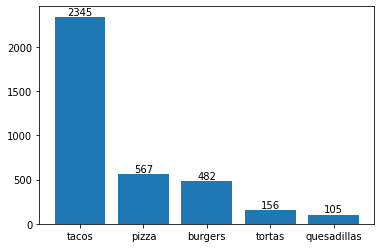

In [11]:
# let's se the frcuency of each category
frecuency = df_food[['Venue Category']].value_counts().reset_index()
frecuency.columns = ['Food Category', 'frecuency']
print(frecuency)
fig, ax = plt.subplots()
plot1 = ax.bar(frecuency['Food Category'], frecuency['frecuency'])
#plot1 = ax.plot(kind='bar')

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 0),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
        
autolabel(plot1)

ax.set_xticklabels(['tacos', 'pizza', 'burgers', 'tortas', 'quesadillas'])
plt.savefig('C:/Users/tino_/Documents/Python_Scripts/python_IBM/capstone_project/frecuency.png',
           dpi = 300, bbox_inches = 'tight')

<section id="item2B"> </section>

### 2B. Street food Representativeness per Neighborhood

I analyze representativeness for tortas, pizza, etc. in each neighborhood.

In [12]:
# one hot encoding
# let's create dummies for each venue type
df_onehot = pd.get_dummies(df_food[['Venue Category']], prefix="", prefix_sep="")
print(df_onehot.shape, df_food.shape)

# move neighborhood column to the first column
df_onehot['Neighborhood'] = df_food['Neighborhood']
columnas = list(df_onehot.columns)
columnas.remove('Neighborhood')
fixed_columns = ['Neighborhood'] + columnas
df_onehot = df_onehot[fixed_columns]
df_onehot.sort_values('Neighborhood', inplace = True)
# every row indicates whether that venue belongs to that category
df_onehot.head()

(3655, 5) (3655, 8)


,Neighborhood,burgers,pizza,quesadillas,tacos,tortas
17858,10 de Abril,0,0,0,0,1
17857,10 de Abril,1,0,0,0,0
17856,10 de Abril,0,0,0,1,0
17867,10 de Abril,0,0,0,1,0
16939,"12 de Diciembre, San Andrés Tomatlán, San Andr...",1,0,0,0,0


Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [13]:
df_grouped = df_onehot.groupby('Neighborhood').mean().reset_index()
print(df_grouped.shape)
df_grouped.head()

(762, 6)


,Neighborhood,burgers,pizza,quesadillas,tacos,tortas
0,10 de Abril,0.25,0.0,0.0,0.500000,0.250000
1,"12 de Diciembre, San Andrés Tomatlán, San Andr...",0.25,0.0,0.0,0.750000,0.000000
2,15 de Agosto,0.00,0.0,0.0,1.000000,0.000000
3,16 de Septiembre,0.20,0.0,0.0,0.800000,0.000000
4,"1a Sección Cañada, 2a Sección Cañada",0.00,0.0,0.0,0.857143,0.142857


First, let's write a function to sort the venues in descending order.

In [14]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 5 venues for each neighborhood (since we only have 5 categories).

In [15]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = df_grouped['Neighborhood']

for ind in np.arange(df_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(df_grouped.iloc[ind, :], num_top_venues)

print(neighborhoods_venues_sorted.shape)
neighborhoods_venues_sorted.head()

(762, 6)


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,10 de Abril,tacos,tortas,burgers,quesadillas,pizza
1,"12 de Diciembre, San Andrés Tomatlán, San Andr...",tacos,burgers,tortas,quesadillas,pizza
2,15 de Agosto,tacos,tortas,quesadillas,pizza,burgers
3,16 de Septiembre,tacos,burgers,tortas,quesadillas,pizza
4,"1a Sección Cañada, 2a Sección Cañada",tacos,tortas,quesadillas,pizza,burgers


<section id="item3"> </section>


## 3. Clustering Neighborhoods

Run _k_-means to cluster the neighborhoods into 3 clusters according to street food representativeness.

<a href="#item0">go up </a>

In [16]:
# First, standarize data
try:
    df_grouped.drop(columns='Clus_km', inplace=True)
except:
    pass
print(df_grouped.head(2))
X = df_grouped.values[:,1:]
#print(X.shape)
X = np.nan_to_num(X)
Clus_dataSet = StandardScaler().fit_transform(X)
Clus_dataSet


                                        Neighborhood  burgers  pizza  \
0                                        10 de Abril     0.25    0.0   
1  12 de Diciembre, San Andrés Tomatlán, San Andr...     0.25    0.0   

   quesadillas  tacos  tortas  
0          0.0   0.50    0.25  
1          0.0   0.75    0.00  


array([[ 0.43815632, -0.70590803, -0.27259275, -0.47689786,  2.09978977],
       [ 0.43815632, -0.70590803, -0.27259275,  0.36191332, -0.3367762 ],
       [-0.6438382 , -0.70590803, -0.27259275,  1.2007245 , -0.3367762 ],
       ...,
       [-0.6438382 , -0.16303806, -0.27259275,  0.45511456,  0.74614201],
       [ 0.22175741, -0.70590803, -0.27259275,  0.52967556, -0.3367762 ],
       [ 1.52015084,  1.73700685, -0.27259275, -2.15452022, -0.3367762 ]])

In [17]:
# Decide number of clusters

Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(init = "k-means++", n_clusters=k, n_init = 12, random_state=0)
    km = km.fit(Clus_dataSet)
    Sum_of_squared_distances.append(km.inertia_)

'\nclusterNum = 3\nk_means = KMeans(init = "k-means++", n_clusters = clusterNum, n_init = 12, random_state=0)\nk_means.fit(Clus_dataSet)\nlabels = k_means.labels_\n# check cluster labels generated for each row in the dataframe\nprint(\'cluster ocurrencies \n\', pd.DataFrame(k_means.labels_)[0].value_counts(dropna=False))\n#print(labels)\n'

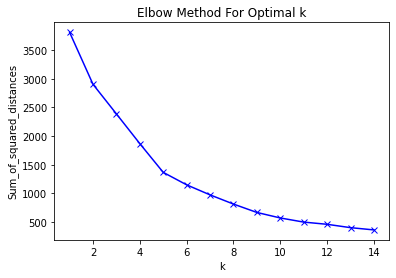

In [20]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.savefig('C:/Users/tino_/Documents/Python_Scripts/python_IBM/capstone_project/elbow.png',
           dpi = 300, bbox_inches = 'tight')
plt.show()

It results optimun number of clusters is 5.

In [60]:
# Cluster neighborhoods

clusterNum = 5
k_means = KMeans(init = "k-means++", n_clusters = clusterNum, n_init = 12, random_state=0)
k_means.fit(Clus_dataSet)
labels = k_means.labels_
# check cluster labels generated for each row in the dataframe
print('cluster ocurrencies \n', pd.DataFrame(k_means.labels_)[0].value_counts(dropna=False))

cluster ocurrencies 
 0    366
1    201
4     95
2     74
3     26
Name: 0, dtype: int64


We assign the labels to each row in dataframe.

In [63]:
df_grouped["Clus_km"] = labels
df_grouped.tail(5)

,Neighborhood,burgers,pizza,quesadillas,tacos,tortas,Clus_km
757,Zona Escolar,0.0,0.000000,0.0,1.000000,0.000000,0
758,Zona Escolar Oriente,1.0,0.000000,0.0,0.000000,0.000000,2
759,Álamos,0.0,0.111111,0.0,0.777778,0.111111,0
760,"Álvaro Obregón, Ejército de Oriente, El Paraís...",0.2,0.000000,0.0,0.800000,0.000000,0
761,Ángel Zimbrón,0.5,0.500000,0.0,0.000000,0.000000,1


We can easily check the centroid values by averaging the features in each cluster.

In [23]:
df_grouped.groupby('Clus_km').mean()

,burgers,pizza,quesadillas,tacos,tortas
Clus_km,,,,,
0,0.063155,0.035265,0.016420,0.881314,0.003846
1,0.141524,0.414585,0.009911,0.429750,0.004231
2,0.696927,0.024654,0.004223,0.268115,0.006081
3,0.083333,0.064103,0.512821,0.339744,0.000000
4,0.084803,0.109101,0.013308,0.544132,0.248656


Now, lets look at the distribution of neighborhoods based on tacos, pizza and tortas:

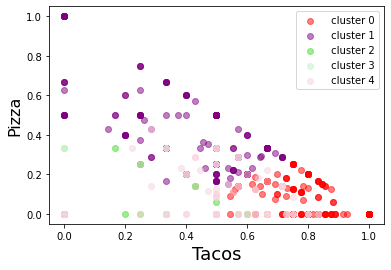

In [97]:
#  burgers=1, pizza=2, quesadilla=3,tacos=4,tortas=5, Clus_km=6
area = np.pi * ( df_grouped.iloc[:, 5])**2  

fig, ax = plt.subplots()
#plt.scatter(df_grouped[:, 3], df_grouped[:, 1], s=area, c=labels.astype(np.float), alpha=0.5)
c0 = df_grouped['Clus_km']==0
c1 = df_grouped['Clus_km']==1
c2 = df_grouped['Clus_km']==2
c3 = df_grouped['Clus_km']==3
c4 = df_grouped['Clus_km']==4
ax.scatter(df_grouped.loc[c0, 'tacos'], df_grouped.loc[c0, 'pizza'], c='red', alpha=0.5, label =' cluster 0')
ax.scatter(df_grouped.loc[c1, 'tacos'], df_grouped.loc[c1, 'pizza'], c='purple', alpha=0.5, label =' cluster 1')
ax.scatter(df_grouped.loc[c2, 'tacos'], df_grouped.loc[c2, 'pizza'], c='#40DC24', alpha=0.5, label =' cluster 2')
ax.scatter(df_grouped.loc[c3, 'tacos'], df_grouped.loc[c3, 'pizza'], c='#BFF3C0', alpha=0.5, label =' cluster 3')
ax.scatter(df_grouped.loc[c4, 'tacos'], df_grouped.loc[c4, 'pizza'], c='#F9D2DE', alpha=0.5, label =' cluster 4')
plt.xlabel('Tacos', fontsize=18)
plt.ylabel('Pizza', fontsize=16)

ax.legend()
plt.savefig('C:/Users/tino_/Documents/Python_Scripts/python_IBM/capstone_project/2d.png',
           dpi = 600, bbox_inches = 'tight')

plt.show()

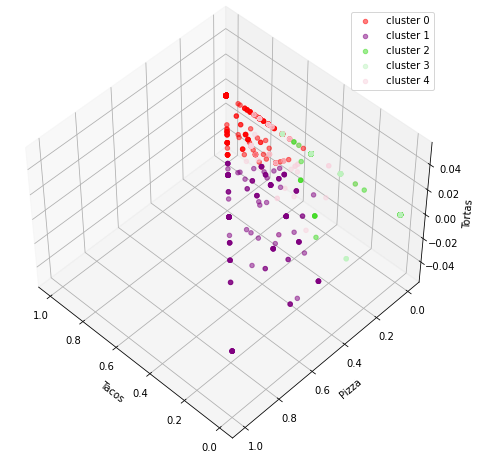

In [96]:
from mpl_toolkits.mplot3d import Axes3D 
fig = plt.figure(1, figsize=(8, 6))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

plt.cla()
# plt.ylabel('Tacos', fontsize=18)
# plt.xlabel('Pizza', fontsize=16)
# plt.zlabel('Tortas', fontsize=16)
ax.set_xlabel('Tacos')
ax.set_ylabel('Pizza')
ax.set_zlabel('Tortas')

#ax.scatter(X[:, 3], X[:, 1], X[:, 4], c= labels.astype(np.float))
ax.scatter(df_grouped.loc[c0, 'tacos'], df_grouped.loc[c0, 'pizza'], c='red', alpha=0.5, label =' cluster 0')
ax.scatter(df_grouped.loc[c1, 'tacos'], df_grouped.loc[c1, 'pizza'], c='purple', alpha=0.5, label =' cluster 1')
ax.scatter(df_grouped.loc[c2, 'tacos'], df_grouped.loc[c2, 'pizza'], c='#40DC24', alpha=0.5, label =' cluster 2')
ax.scatter(df_grouped.loc[c3, 'tacos'], df_grouped.loc[c3, 'pizza'], c='#BFF3C0', alpha=0.5, label =' cluster 3')
ax.scatter(df_grouped.loc[c4, 'tacos'], df_grouped.loc[c4, 'pizza'], c='#F9D2DE', alpha=0.5, label =' cluster 4')

ax.legend()

plt.savefig('C:/Users/tino_/Documents/Python_Scripts/python_IBM/capstone_project/3d.png',
           dpi = 300, bbox_inches = 'tight')

In [93]:
#assign coordinates to each neighborhood

df_grouped["Clus_km"] = df_grouped["Clus_km"].astype('int')

# merge df_grouped with df3 to add latitude/longitude for each neighborhood
# note we have to do inner merge since for some postal codes we were not able to find venues
df_merged = df_grouped.merge(df3, on='Neighborhood', how='inner')
df_merged.sort_values('Clus_km', inplace=True)

print(df_merged.shape)
df_merged.tail(8) # check the last columns

(810, 11)


,Neighborhood,burgers,pizza,quesadillas,tacos,tortas,Clus_km,Postal Code,Borough,Latitude,Longitude
728,Santa Úrsula Coapa,0.250000,0.125000,0.000,0.500000,0.125000,4,4650,Coyoacán,19.3156,-99.14310
469,Mariano Escobedo,0.142857,0.285714,0.000,0.428571,0.142857,4,11310,Miguel Hidalgo,19.4445,-99.18110
471,Maza,0.000000,0.000000,0.000,0.571429,0.428571,4,6270,Cuauhtémoc,19.4547,-99.12790
482,Miravalle,0.000000,0.125000,0.125,0.625000,0.125000,4,3580,Benito Juárez,19.3611,-99.14090
484,Mixcoac,0.090909,0.000000,0.000,0.727273,0.181818,4,3910,Benito Juárez,19.3730,-99.18880
492,Narvarte Poniente,0.250000,0.000000,0.000,0.625000,0.125000,4,3020,Benito Juárez,19.4201,-99.14485
420,"Lindavista Norte, Lindavista Sur",0.166667,0.000000,0.000,0.666667,0.166667,4,7300,"Gustavo A. Madero, Gustavo A. Madero",19.5039,-99.13250
0,10 de Abril,0.250000,0.000000,0.000,0.500000,0.250000,4,11250,Miguel Hidalgo,19.4486,-99.21100


In [94]:
# number of clusters per type
print(df_merged['Clus_km'].value_counts(dropna=False))

0    390
1    215
4    102
2     75
3     28
Name: Clus_km, dtype: int64


Finally, let's visualize the resulting clusters

In [95]:
# Mexico City coordinates
latitude = 19.432608
longitude = -99.133209

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(clusterNum)
ys = [i + x + (i*x)**2 for i in range(clusterNum)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
#print(rainbow)

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_merged['Latitude'], df_merged['Longitude'], df_merged['Neighborhood'], df_merged['Clus_km']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=3,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[int(cluster-1)],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

<section id="item4"> </section>

## 4. Examining clusters

We compare the food venues that characterize each cluster 

<a href="#item0">go up </a>

In [110]:
col_sel = ['Neighborhood','burgers','pizza','quesadillas','tacos','tortas','Clus_km']
df_merged2 = df_merged[col_sel]
print('ocurrencies per cluster')
print(df_merged2['Clus_km'].value_counts())
print('means per cluster')
print(df_merged2[['burgers','pizza','quesadillas','tacos','tortas','Clus_km']].groupby('Clus_km').mean())

ocurrencies per cluster
0    390
1    215
4    102
2     75
3     28
Name: Clus_km, dtype: int64
means per cluster
          burgers     pizza  quesadillas     tacos    tortas
Clus_km                                                     
0        0.063307  0.039313     0.018002  0.875768  0.003609
1        0.134216  0.409322     0.010247  0.441836  0.004378
2        0.700968  0.024325     0.004167  0.264540  0.006000
3        0.077381  0.083333     0.523810  0.315476  0.000000
4        0.087537  0.109599     0.016388  0.543003  0.243473


#### Cluster 0
This is the most common cluster. We note it is characterized by a overwhelming presence of tacos venues. In the map above we don't see any important geo-pattern in its distribution since all neighborhoods belonging to this cluster are uniformly distribuited across the city. Nontheless, we see some dense zones, with importat presence of cluster 0. 

In [99]:
col_sel = ['Neighborhood','burgers','pizza','quesadillas','tacos','tortas','Clus_km']
print(df_merged2[df_merged2['Clus_km'] == 0].mean())
df_merged2.loc[df_merged2['Clus_km'] == 0].head()

burgers        0.063307
pizza          0.039313
quesadillas    0.018002
tacos          0.875768
tortas         0.003609
Clus_km        0.000000
dtype: float64


,Neighborhood,burgers,pizza,quesadillas,tacos,tortas,Clus_km
750,Tepetongo,0.0,0.000000,0.0,1.000000,0.0,0
303,Granjas Modernas,0.0,0.000000,0.0,1.000000,0.0,0
302,"Granjas Esmeralda, Los Cipreses, Minerva, Prog...",0.0,0.000000,0.0,1.000000,0.0,0
300,Granjas Cabrera,0.0,0.000000,0.0,1.000000,0.0,0
298,Gertrudis Sánchez 3a Sección,0.0,0.153846,0.0,0.846154,0.0,0


#### Cluster 1
This is the second most common cluster. We note it is characterized by a predominance of pizza and tacos bussinesses. The other food types remain weakly represented. In the map above we don't see any geo-pattern since this cluster is uniformly distribuited across the city. Nontheless, alike to cluster 0, we note some zones with high predominance and grouping of cluster 1.

In [100]:
print(df_merged2[df_merged2['Clus_km'] == 1].mean())
df_merged2.loc[df_merged2['Clus_km'] == 1].head()

burgers        0.134216
pizza          0.409322
quesadillas    0.010247
tacos          0.441836
tortas         0.004378
Clus_km        1.000000
dtype: float64


,Neighborhood,burgers,pizza,quesadillas,tacos,tortas,Clus_km
459,"Los Reyes, San Rafael, Nuevo Barrio San Rafael",0.000000,1.000000,0.000000,0.000000,0.0,1
584,Rancho los Colorines,0.181818,0.181818,0.090909,0.545455,0.0,1
460,Los Sauces,0.125000,0.625000,0.000000,0.250000,0.0,1
461,Los Volcanes,0.000000,0.333333,0.000000,0.666667,0.0,1
588,Real del Moral,0.000000,0.666667,0.000000,0.333333,0.0,1


#### Cluster 2
This cluster is the second less common. We note it is characterized by a important predominance of hamburger places with a weaker presence of tacos. The other food types are not importantly present. Likewise, we don't see any geo-pattern.

In [101]:
print(df_merged2[df_merged2['Clus_km'] == 2].mean())
df_merged2.loc[df_merged2['Clus_km'] == 2].head()

burgers        0.700968
pizza          0.024325
quesadillas    0.004167
tacos          0.264540
tortas         0.006000
Clus_km        2.000000
dtype: float64


,Neighborhood,burgers,pizza,quesadillas,tacos,tortas,Clus_km
656,San Juan de Aragón VII Sección,0.5,0.00,0.0,0.50,0.0,2
655,San Juan de Aragón VI Sección,0.5,0.00,0.0,0.50,0.0,2
654,"San Juan de Aragón IV Sección, San Juan de Ara...",0.5,0.00,0.0,0.50,0.0,2
653,San Juan de Aragón III Sección,0.5,0.00,0.0,0.50,0.0,2
725,Santa María Ticomán,0.5,0.25,0.0,0.25,0.0,2


#### Cluster 3
This is the less common cluster. We note it is characterized by an important predominance of quesadillas bussinesses with a weaker presence of tacos. The other food types are not importantly present. Likewise, we don't see any geo-pattern.

In [102]:
print(df_merged2[df_merged2['Clus_km'] == 3].mean())
df_merged2.loc[df_merged2['Clus_km'] == 3].head()

burgers        0.077381
pizza          0.083333
quesadillas    0.523810
tacos          0.315476
tortas         0.000000
Clus_km        3.000000
dtype: float64


,Neighborhood,burgers,pizza,quesadillas,tacos,tortas,Clus_km
691,San Salvador Xochimanca,0.000000,0.0,0.666667,0.333333,0.0,3
794,Villa de Aragón,0.333333,0.0,0.333333,0.333333,0.0,3
697,San Ángel,0.000000,0.0,0.666667,0.333333,0.0,3
724,Santa María Nonoalco,0.000000,0.0,0.333333,0.666667,0.0,3
404,La Venta,0.000000,0.0,0.500000,0.500000,0.0,3


#### Cluster 4
This is the 3rd most common cluster. We note it is characterized by an important predominance of tacos bussiness with a weaker presence of tortas and pizza. The other food types are not importantly present. For this cluster we see a geo-pattern, where most of branches place in the city center.

In [103]:
print(df_merged2[df_merged2['Clus_km'] == 4].mean())
df_merged2.loc[df_merged2['Clus_km'] == 4].head()

burgers        0.087537
pizza          0.109599
quesadillas    0.016388
tacos          0.543003
tortas         0.243473
Clus_km        4.000000
dtype: float64


,Neighborhood,burgers,pizza,quesadillas,tacos,tortas,Clus_km
276,Ex-Hacienda de Guadalupe Chimalistac,0.166667,0.000000,0.0,0.666667,0.166667,4
141,Centro (Área 9),0.000000,0.142857,0.0,0.714286,0.142857,4
144,"Chimalcoyoc, Villa Tlalpan",0.142857,0.000000,0.0,0.571429,0.285714,4
279,Felipe Pescador,0.000000,0.000000,0.0,0.500000,0.500000,4
157,"Coltongo, Coltongo",0.000000,0.000000,0.0,0.000000,1.000000,4


## Conclusion

We have identified neighborhhods by the prdominance of certain mexican food. This information might be helpful to decide where to start a new business, depending on the type of food we want to offer. Le't say we want to start a new quesadillas bussiness, then we now know that in neighborhoods in cluster 3 there is high demand for this type of food given the predominance of these bussinesses. Nontheless, this also implies there is high competition with other quesadilla bussinesses, and a minor competition with taco places, given their weaker presence.